In [ ]:
project_name="red rot image generator"

In [ ]:
!wget "https://github.com/NatanshK/IGEM-IITR-Drylab/tree/main/DATASET/HEALTHYOA"


--2024-08-26 15:14:40--  https://github.com/NatanshK/IGEM-IITR-Drylab/tree/main/DATASET/HEALTHYOA
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘HEALTHYOA’

HEALTHYOA               [  <=>               ] 592.88K  2.80MB/s    in 0.2s    

2024-08-26 15:14:41 (2.80 MB/s) - ‘HEALTHYOA’ saved [607104]



In [ ]:
!git clone https://github.com/NatanshK/IGEM-IITR-Drylab.git


Cloning into 'IGEM-IITR-Drylab'...
remote: Enumerating objects: 8138, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 8138 (delta 0), reused 3 (delta 0), pack-reused 8135 (from 1)
Receiving objects: 100% (8138/8138), 533.09 MiB | 24.81 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [40]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
repo_path = '/content/IGEM-IITR-Drylab'
DATA_DIR = os.path.join(repo_path, 'DATASET') # Added the HEALTHYOA folder to the path

# List all JPEG files in the directory
image_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.jpeg')]

# Load a sample of images
sample_images = []
for i in range(min(8, len(image_files))):
    img_path = os.path.join(DATA_DIR, image_files[i])
    img = Image.open(img_path).resize((100, 100))  # Resize to 100x100 pixels
    sample_images.append(img)

# Display images in a grid
def show_images(images, titles=None, cols=4):
    """Display a list of images in a grid with smaller size."""
    n = len(images)
    if n == 0: # Handle the case where no images are found
        print("No images found in the directory.")
        return

    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(images[i])
            ax.axis('off')
            if titles is not None:
                ax.set_title(titles[i])
        else:
            ax.axis('off')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Show the images
show_images(sample_images, titles=[f'Image {i+1}' for i in range(len(sample_images))])


No images found in the directory.


In [41]:
!pip install pillow matplotlib


In [42]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [43]:
image_size =64
batch_size =20
stats =(0.5,0.5,0.5),(0.5,0.5,0.5)
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
import os

# Verify the path exists
if not os.path.exists(DATA_DIR):
    print(f"Error: Directory not found: {DATA_DIR}")
    # Try correcting the path or provide an alternative
    DATA_DIR = "C:/Users/prish/Downloads/combined_2/Healthy"  # Replace with the correct path
    print(f"Trying alternative path: {DATA_DIR}")

# Rest of your code remains the same
# train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     T.ToTensor(),
#     T.Normalize(*stats)]))

# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [46]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [48]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

# New Section

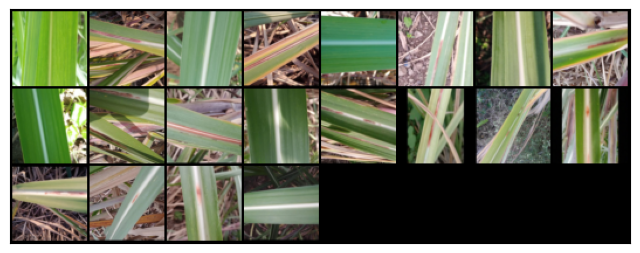

In [49]:
show_batch(train_dl)

In [50]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.1 MB/s eta 0:00:00


In [51]:
import jovian

jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [53]:
device = get_default_device()
device

device(type='cpu')

In [54]:
train_dl = DeviceDataLoader(train_dl, device)

In [55]:
import torch.nn as nn

In [56]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [58]:
discriminator = to_device(discriminator, device)

In [60]:
latent_size = 20

In [61]:
import torch.nn as nn
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [62]:
!pip install torch torchvision
import torch

# ... rest of your code ...
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
# show_images(fake_images) # Assuming show_images is defined elsewhere

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [63]:
generator = to_device(generator, device)

In [64]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [65]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [66]:
from torchvision.utils import save_image

In [67]:
import os
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [68]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [69]:
import torch
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


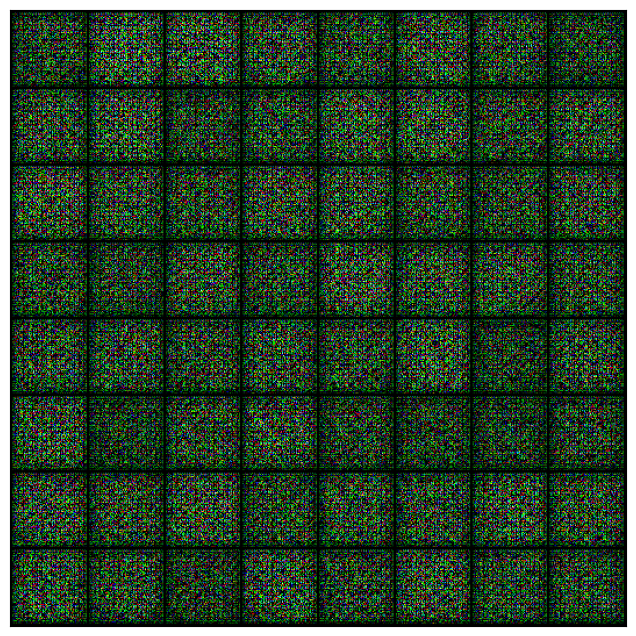

In [70]:
save_samples(0, fixed_latent)

In [71]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [72]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [73]:
lr = 0.0002
epochs = 10

In [74]:
history = fit(epochs, lr)

  0%|          | 0/416 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], loss_g: 6.6058, loss_d: 0.8417, real_score: 0.9426, fake_score: 0.4764
Saving generated-images-0001.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.0444, loss_d: 0.4842, real_score: 0.9526, fake_score: 0.3018
Saving generated-images-0002.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 4.7345, loss_d: 0.1138, real_score: 0.9405, fake_score: 0.0460
Saving generated-images-0003.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.9585, loss_d: 0.3576, real_score: 0.9767, fake_score: 0.2628
Saving generated-images-0004.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 3.0999, loss_d: 0.1773, real_score: 0.9341, fake_score: 0.0927
Saving generated-images-0005.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 10.1846, loss_d: 1.5083, real_score: 0.9872, fake_score: 0.6794
Saving generated-images-0006.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 9.8268, loss_d: 1.7877, real_score: 0.9804, fake_score: 0.6426
Saving generated-images-0007.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.7679, loss_d: 0.2501, real_score: 0.8251, fake_score: 0.0056
Saving generated-images-0008.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 3.3491, loss_d: 0.2063, real_score: 0.8630, fake_score: 0.0183
Saving generated-images-0009.png


  0%|          | 0/416 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 2.8175, loss_d: 0.5994, real_score: 0.7371, fake_score: 0.0686
Saving generated-images-0010.png


In [75]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [77]:
from IPython.display import Image

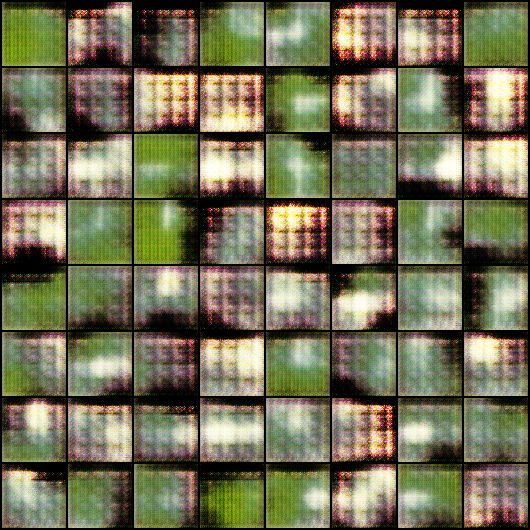

In [78]:
Image('./generated/generated-images-0001.png')

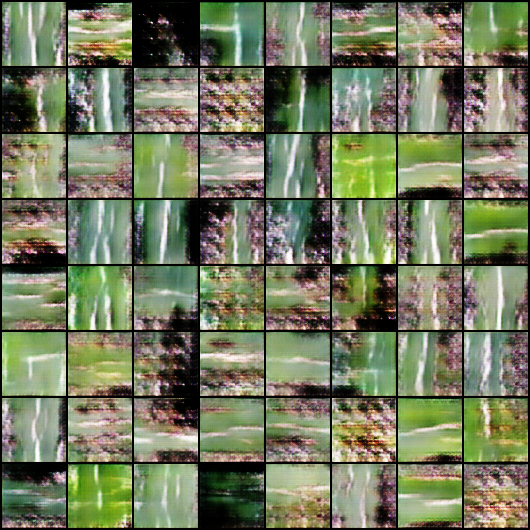

In [79]:
Image('./generated/generated-images-0005.png')

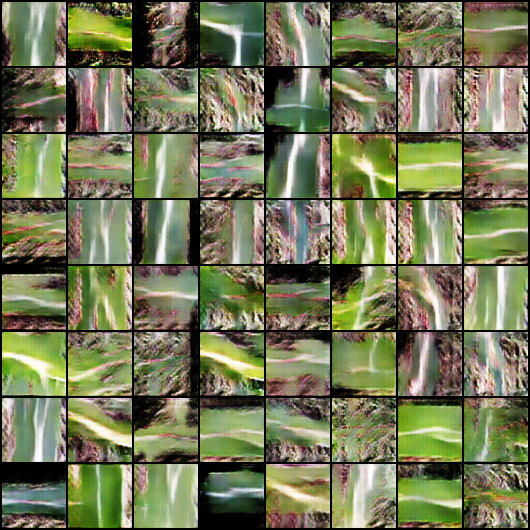

In [80]:
Image('./generated/generated-images-0010.png')

In [84]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

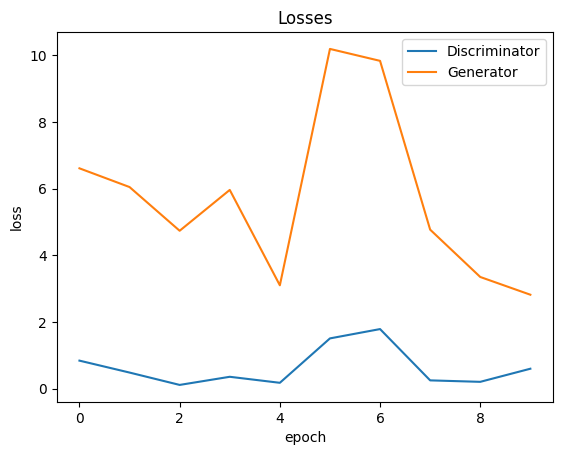

In [85]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

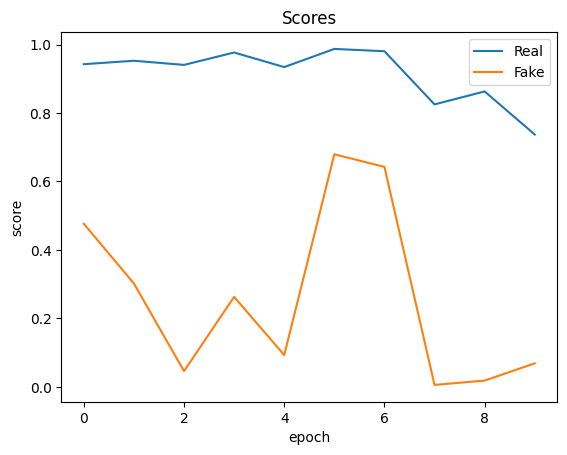

In [86]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');